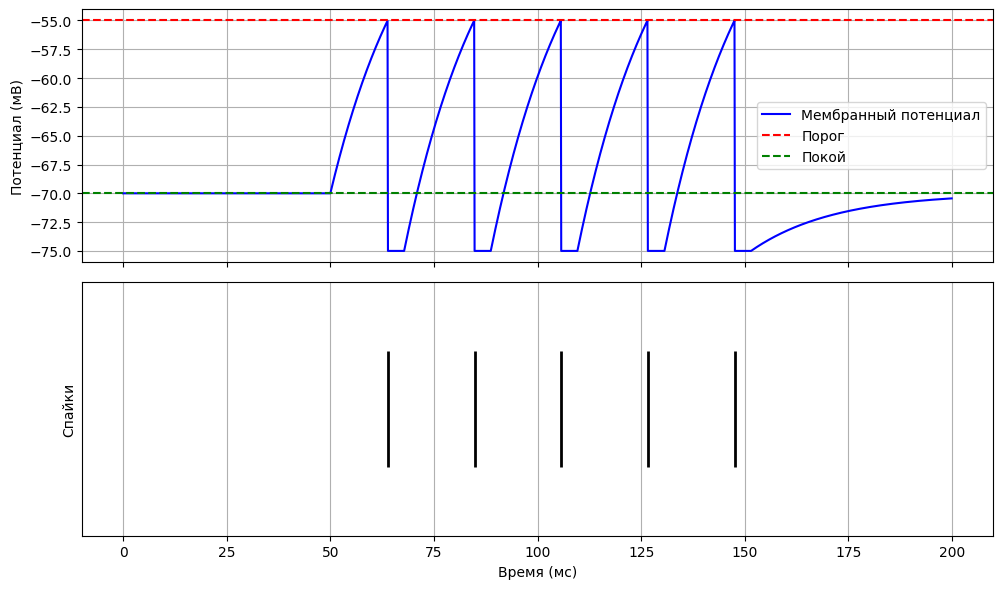

Количество спайков: 5


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import List, Dict, Tuple
import copy
import random
import tensorflow as tf
from keras.datasets import mnist

# Фиксируем seed для воспроизводимости
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

# Параметры STDP
STDP_PARAMS = {
    'A_plus': 0.005,    # Усиление при положительном Δt
    'A_minus': 0.0052,  # Слабое подавление для стабильности (A_minus > A_plus)
    'tau_plus': 20.0,   # Постоянная времени для потенцирования (мс)
    'tau_minus': 20.0,  # Постоянная времени для депрессии (мс)
    'w_max': 1.0,       # Максимальный вес
    'w_min': 0.0        # Минимальный вес
}

# Определение параметров нейрона LIF
@dataclass
class LIFNeuron:
    tau_m: float = 20.0    # Постоянная времени мембраны (мс)
    v_rest: float = -70.0  # Потенциал покоя (мВ)
    v_thresh: float = -55.0 # Пороговый потенциал (мВ)
    v_reset: float = -75.0 # Потенциал сброса (мВ)
    r_m: float = 10.0      # Мембранное сопротивление (МОм)
    tau_ref: float = 4.0   # Рефрактерный период (мс)

    def __post_init__(self):
        self.v = self.v_rest
        self.refractory_until = 0
        self.spike_times = []

    def step(self, I_inj: float, dt: float, t: float) -> bool:
        """Один шаг интегрирования. Возвращает True, если был спайк."""
        # Проверка рефрактерности
        if t < self.refractory_until:
            self.v = self.v_reset
            return False

        # Интегрирование уравнения LIF (простая Эйлерова схема)
        dv = (-(self.v - self.v_rest) + self.r_m * I_inj) / self.tau_m
        self.v += dv * dt

        # Проверка на срабатывание
        if self.v >= self.v_thresh:
            self.v = self.v_reset
            self.refractory_until = t + self.tau_ref
            self.spike_times.append(t)
            return True
        return False

class Synapse:
    def __init__(self, pre_idx: int, post_idx: int, weight: float, delay: float = 1.0):
        """Инициализация синапса с STDP-трассировкой"""
        self.pre_idx = pre_idx       # Индекс пресинаптического нейрона
        self.post_idx = post_idx     # Индекс постсинаптического нейрона
        self.weight = weight         # Вес синапса
        self.delay = delay           # Задержка (мс)
        
        # Для STDP
        self.pre_trace = 0.0         # Пресинаптический след
        self.post_trace = 0.0        # Постсинаптический след
        self.weight_history = [weight]  # История весов для анализа
    
    def update_weight(self, delta_t: float):
        """Обновление веса по правилу STDP"""
        if delta_t > 0:  # Пресинаптический спайк раньше постсинаптического
            delta_w = STDP_PARAMS['A_plus'] * np.exp(-delta_t / STDP_PARAMS['tau_plus'])
            self.weight = min(STDP_PARAMS['w_max'], self.weight + delta_w)
        else:  # Постсинаптический спайк раньше пресинаптического
            delta_w = -STDP_PARAMS['A_minus'] * np.exp(delta_t / STDP_PARAMS['tau_minus'])
            self.weight = max(STDP_PARAMS['w_min'], self.weight + delta_w)
            
        self.weight_history.append(self.weight)

class SpikingNetwork:
    def __init__(self, neuron_params: dict, num_neurons: int, dt: float = 0.1):
        """Инициализация спайковой сети"""
        self.neurons = [LIFNeuron(**neuron_params) for _ in range(num_neurons)]
        self.synapses: List[Synapse] = []
        self.spike_history = {i: [] for i in range(num_neurons)}
        self.current_time = 0.0
        self.dt = dt  # ms
        self.event_queue = []  # Для обработки задержек спайков
    
    def add_synapse(self, pre_idx: int, post_idx: int, weight: float, delay: float = 1.0):
        """Добавляет синапс с STDP-трассировкой"""
        if 0 <= pre_idx < len(self.neurons) and 0 <= post_idx < len(self.neurons):
            self.synapses.append(Synapse(
                pre_idx=pre_idx,
                post_idx=post_idx,
                weight=weight,
                delay=delay
            ))
        else:
            raise ValueError("Invalid neuron indices for synapse")
    
    def reset(self):
        """Сброс состояния сети"""
        for neuron in self.neurons:
            neuron.v = neuron.v_rest
            neuron.refractory_until = 0
            neuron.spike_times = []
        self.spike_history = {i: [] for i in range(len(self.neurons))}
        self.current_time = 0.0
        self.event_queue = []
    
    def step(self, input_currents: np.ndarray, t: float):
        """Один шаг симуляции всей сети"""
        self.current_time = t
        new_spikes = []
        
        # Обрабатываем запланированные события (спайки с задержкой)
        events_to_process = []
        for event_time, pre_idx, post_idx in self.event_queue:
            if event_time <= t:
                events_to_process.append((pre_idx, post_idx))
        
        # Удаляем обработанные события
        self.event_queue = [event for event in self.event_queue if event[0] > t]
        
        # Добавляем синаптический ток от пришедших спайков
        synaptic_current = np.zeros(len(self.neurons))
        for pre_idx, post_idx in events_to_process:
            for syn in self.synapses:
                if syn.pre_idx == pre_idx and syn.post_idx == post_idx:
                    synaptic_current[post_idx] += syn.weight
        
        # Обрабатываем каждый нейрон
        for i, neuron in enumerate(self.neurons):
            # Общий ток = внешний + синаптический
            total_current = input_currents[i] + synaptic_current[i]
            
            # Делаем шаг нейрона
            spike = neuron.step(total_current, self.dt, t)
            
            # Обрабатываем спайк
            if spike:
                new_spikes.append(i)
                self.spike_history[i].append(t)
                
                # Планируем прибытие спайка в постсинаптические нейроны с учетом задержки
                for syn in self.synapses:
                    if syn.pre_idx == i:
                        event_time = t + syn.delay
                        self.event_queue.append((event_time, i, syn.post_idx))
                
                # Обновляем следы для STDP
                for syn in self.synapses:
                    if syn.pre_idx == i:  # Это пресинаптический спайк
                        syn.pre_trace = 1.0
                        # Применяем STDP к существующим постсинаптическим следам
                        for post_spike_time in self.spike_history.get(syn.post_idx, []):
                            delta_t = t - post_spike_time
                            if 0 < delta_t < 100:  # Ограничение по времени
                                syn.update_weight(delta_t)
                    if syn.post_idx == i:  # Это постсинаптический спайк
                        syn.post_trace = 1.0
                        # Применяем STDP к существующим пресинаптическим следам
                        for pre_spike_time in self.spike_history.get(syn.pre_idx, []):
                            delta_t = pre_spike_time - t
                            if 0 < -delta_t < 100:  # Ограничение по времени
                                syn.update_weight(delta_t)
        
        # Экспоненциальное затухание следов
        for syn in self.synapses:
            syn.pre_trace *= np.exp(-self.dt / STDP_PARAMS['tau_plus'])
            syn.post_trace *= np.exp(-self.dt / STDP_PARAMS['tau_minus'])
        
        return new_spikes

def mnist_latency_coding(image: np.ndarray, T_max: float = 100.0) -> np.ndarray:
    """
    Преобразует изображение MNIST в спайковую активность по latency coding.
    
    Args:
        image: исходное изображение 28x28 (0-255)
        T_max: максимальное время симуляции (мс)
    
    Returns:
        Массив времен первых спайков для каждого пикселя (мс)
    """
    # Нормализуем и инвертируем яркость (белый = 0 спайк, черный = T_max)
    normalized = 1.0 - (image / 255.0).flatten()
    
    # Время первого спайка: t = T_max * (1 - яркость)
    spike_times = T_max * normalized
    
    # Для очень темных пикселей (яркость близка к 0) не генерируем спайков
    spike_times[image.flatten() < 10] = np.inf  # Порог для "черных" пикселей
    
    return spike_times

def plot_neuron_activity(t_range: np.ndarray, v_trace: List[float], spike_times: List[float], neuron=None):
    """Визуализация потенциала и спайков одного нейрона"""
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

    ax1.plot(t_range, v_trace, 'b-', label='Мембранный потенциал')
    if neuron:
        ax1.axhline(y=neuron.v_thresh, color='r', linestyle='--', label='Порог')
        ax1.axhline(y=neuron.v_rest, color='g', linestyle='--', label='Покой')
    ax1.set_ylabel('Потенциал (мВ)')
    ax1.legend()
    ax1.grid(True)

    ax2.eventplot(spike_times, colors='k', linewidths=2)
    ax2.set_xlabel('Время (мс)')
    ax2.set_ylabel('Спайки')
    ax2.set_yticks([])
    ax2.grid(True)

    plt.tight_layout()
    plt.savefig('lif_neuron_debug.png', dpi=150)
    plt.show()

def plot_network_activity(spike_history: Dict[int, List[float]], T_max: float, title: str = "Активность сети"):
    """Визуализация растер-плота для всей сети"""
    plt.figure(figsize=(12, 8))
    
    spike_times = []
    neuron_ids = []
    for neuron_id, spikes in spike_history.items():
        for t in spikes:
            if t <= T_max:
                spike_times.append(t)
                neuron_ids.append(neuron_id)
    
    plt.scatter(spike_times, neuron_ids, s=2, alpha=0.7)
    plt.title(title)
    plt.xlabel('Время (мс)')
    plt.ylabel('Номер нейрона')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('raster_plot.png', dpi=150)
    plt.show()

def plot_weight_dynamics(synapses: List[Synapse], num_to_show: int = 5):
    """Визуализация динамики весов для STDP"""
    plt.figure(figsize=(10, 6))
    
    for i, syn in enumerate(synapses[:num_to_show]):
        plt.plot(syn.weight_history, alpha=0.7, label=f'Syn {i} ({syn.pre_idx}->{syn.post_idx})')
    
    plt.title('Динамика синаптических весов (STDP)')
    plt.xlabel('Временной шаг')
    plt.ylabel('Вес')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('weight_dynamics.png', dpi=150)
    plt.show()

def plot_classification_results(accuracy_history: List[float], energy_history: List[float]):
    """Визуализация результатов классификации и энергопотребления"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Точность
    ax1.plot(accuracy_history, 'o-')
    ax1.set_title('Точность классификации')
    ax1.set_xlabel('Эпоха')
    ax1.set_ylabel('Точность')
    ax1.grid(True)
    
    # Энергопотребление
    ax2.plot(energy_history, 's-')
    ax2.set_title('Энергопотребление (условные единицы)')
    ax2.set_xlabel('Эпоха')
    ax2.set_ylabel('Энергия')
    ax2.grid(True)
    
    plt.tight_layout()
    plt.savefig('classification_results.png', dpi=150)
    plt.show()

def test_lif_neuron():
    """Тестирование одного LIF-нейрона с постоянным током"""
    print("=== Тестирование одного LIF-нейрона ===")
    
    # Параметры симуляции
    dt = 0.1  # шаг по времени (мс)
    T = 200   # общее время симуляции (мс)
    t_range = np.arange(0, T, dt)

    # Создание нейрона
    neuron = LIFNeuron()

    # Входной ток: ступенька
    I_inj = np.zeros_like(t_range)
    I_inj[(t_range > 50) & (t_range < 150)] = 3.0  # nA

    # Симуляция
    v_trace = []
    spike_times = []

    for i, t in enumerate(t_range):
        spike = neuron.step(I_inj[i], dt, t)
        v_trace.append(neuron.v)
        if spike:
            spike_times.append(t)

    # Визуализация
    plot_neuron_activity(t_range, v_trace, spike_times, neuron)
    print(f"Количество спайков: {len(spike_times)}")
    print("Тест LIF-нейрона завершен.\n")

def test_two_neuron_network():
    """Тестирование сети из двух нейронов с STDP"""
    print("=== Тестирование сети из двух нейронов с STDP ===")
    
    # Параметры
    dt = 0.1
    T_max = 100.0
    num_steps = int(T_max / dt)
    t_range = np.arange(0, T_max, dt)
    
    # Создаем сеть
    net = SpikingNetwork(
        neuron_params={
            'tau_m': 20.0,
            'v_rest': -70.0,
            'v_thresh': -55.0,
            'v_reset': -75.0,
            'r_m': 10.0,
            'tau_ref': 4.0
        },
        num_neurons=2,
        dt=dt
    )
    
    # Добавляем синапс
    net.add_synapse(0, 1, weight=0.3, delay=2.0)
    
    # Входной ток: только для первого нейрона
    input_currents = np.zeros((2, num_steps))
    input_currents[0, 200:800] = 3.0  # Стимуляция 20-80 мс
    
    # Симуляция
    for step in range(num_steps):
        t = step * dt
        _ = net.step(input_currents[:, step], t)
    
    # Визуализация
    plot_network_activity(net.spike_history, T_max, "Тест двухнейронной сети")
    plot_weight_dynamics(net.synapses)
    
    print(f"Количество спайков: нейрон 0: {len(net.spike_history[0])}, нейрон 1: {len(net.spike_history[1])}")
    print(f"Итоговый вес синапса: {net.synapses[0].weight:.4f}")
    print("Тест двухнейронной сети завершен.\n")

def run_mnist_classification():
    """Основная функция для классификации MNIST с использованием SNN"""
    print("=== Классификация MNIST с использованием SNN ===")
    
    # Параметры
    T_max = 100.0  # ms
    dt = 0.1
    num_steps = int(T_max / dt)
    input_size = 28 * 28
    output_size = 10  # для 10 классов MNIST
    num_train = 1000  # уменьшенный датасет для быстрой симуляции
    num_test = 200
    num_epochs = 3
    
    # Инициализируем сеть
    net = SpikingNetwork(
        neuron_params={
            'tau_m': 20.0,
            'v_rest': -70.0,
            'v_thresh': -55.0,
            'v_reset': -75.0,
            'r_m': 10.0,
            'tau_ref': 4.0
        },
        num_neurons=input_size + output_size,
        dt=dt
    )
    
    # Добавляем синапсы (вход -> выход) с случайными весами
    for i in range(input_size):
        for j in range(output_size):
            w = 0.1 + 0.4 * np.random.rand()  # Веса в диапазоне [0.1, 0.5]
            net.add_synapse(i, input_size + j, weight=w, delay=1.5)
    
    # Загрузка и подготовка данных
    print("Загрузка и подготовка данных MNIST...")
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    
    # Уменьшаем датасет и нормализуем
    x_train, y_train = x_train[:num_train], y_train[:num_train]
    x_test, y_test = x_test[:num_test], y_test[:num_test]
    
    # Инвертируем и нормализуем (белый = 0, черный = 1)
    x_train = (255 - x_train).astype(np.float32) / 255.0
    x_test = (255 - x_test).astype(np.float32) / 255.0
    
    # Обучение
    print(f"Начало обучения на {num_train} образцах, {num_epochs} эпох...")
    accuracy_history = []
    energy_history = []
    weight_snapshots = []
    
    for epoch in range(num_epochs):
        correct = 0
        total_spikes = 0
        
        # Проход по обучающему набору
        for i in range(len(x_train)):
            net.reset()
            
            # Кодируем изображение в спайки
            spike_times = mnist_latency_coding(x_train[i], T_max=T_max)
            
            # Симуляция
            output_spikes = {j: [] for j in range(input_size, input_size + output_size)}
            
            for step in range(num_steps):
                t = step * dt
                
                # Формируем входной ток (3.0 nA для активных пикселей)
                I_inj = np.zeros(input_size + output_size)
                for pixel_idx, t_spike in enumerate(spike_times):
                    if t >= t_spike and t < t_spike + dt:
                        I_inj[pixel_idx] = 3.0
                
                # Делаем шаг сети
                spikes = net.step(I_inj, t)
                
                # Сохраняем выходные спайки
                for spike_idx in spikes:
                    if spike_idx >= input_size:
                        output_spikes[spike_idx].append(t)
            
            # Классификация по числу спайков в выходном слое
            spike_counts = [len(spikes) for spikes in output_spikes.values()]
            predicted_class = np.argmax(spike_counts)
            
            if predicted_class == y_train[i]:
                correct += 1
            
            # Считаем общее количество спайков для оценки энергопотребления
            total_spikes += sum(len(spikes) for spikes in net.spike_history.values())
            
            # Логирование каждые 100 образцов
            if (i + 1) % 100 == 0:
                print(f"Эпоха {epoch+1}/{num_epochs}, Образец {i+1}/{len(x_train)}, "
                      f"Точность: {correct/(i+1):.4f}")
        
        # Сохраняем результаты эпохи
        accuracy = correct / len(x_train)
        energy = total_spikes / len(x_train)  # спайков на образец
        accuracy_history.append(accuracy)
        energy_history.append(energy)
        weight_snapshots.append(copy.deepcopy(net.synapses[0].weight_history))
        
        print(f"Эпоха {epoch+1} завершена. Точность: {accuracy:.4f}, "
              f"Энергия: {energy:.1f} спайков/образец\n")
    
    # Тестирование на тестовом наборе
    print("Тестирование на тестовом наборе...")
    correct = 0
    for i in range(len(x_test)):
        net.reset()
        
        # Кодируем изображение
        spike_times = mnist_latency_coding(x_test[i], T_max=T_max)
        
        # Симуляция
        output_spikes = {j: [] for j in range(input_size, input_size + output_size)}
        
        for step in range(num_steps):
            t = step * dt
            I_inj = np.zeros(input_size + output_size)
            for pixel_idx, t_spike in enumerate(spike_times):
                if t >= t_spike and t < t_spike + dt:
                    I_inj[pixel_idx] = 3.0
            _ = net.step(I_inj, t)
            for j in range(input_size, input_size + output_size):
                if j in net.spike_history and net.spike_history[j]:
                    output_spikes[j] = net.spike_history[j]
        
        # Классификация
        spike_counts = [len(spikes) for spikes in output_spikes.values()]
        predicted_class = np.argmax(spike_counts)
        
        if predicted_class == y_test[i]:
            correct += 1
    
    test_accuracy = correct / len(x_test)
    print(f"Точность на тестовом наборе: {test_accuracy:.4f}")
    
    # Визуализация результатов
    print("Сохранение результатов визуализации...")
    plot_network_activity(net.spike_history, T_max, "Растер-плот активности сети")
    plot_weight_dynamics(net.synapses, num_to_show=10)
    plot_classification_results(accuracy_history, energy_history)
    
    # Анализ устойчивости к шуму
    print("Анализ устойчивости к шуму...")
    noise_levels = [0.0, 0.1, 0.2, 0.3]
    noise_accuracies = []
    
    for noise in noise_levels:
        correct = 0
        for i in range(len(x_test)):
            # Добавляем шум
            noisy_img = x_test[i] + noise * np.random.randn(*x_test[i].shape)
            noisy_img = np.clip(noisy_img, 0, 1)
            
            # Кодируем изображение
            spike_times = mnist_latency_coding(noisy_img, T_max=T_max)
            
            # Симуляция
            net.reset()
            for step in range(num_steps):
                t = step * dt
                I_inj = np.zeros(input_size + output_size)
                for pixel_idx, t_spike in enumerate(spike_times):
                    if t >= t_spike and t < t_spike + dt:
                        I_inj[pixel_idx] = 3.0
                _ = net.step(I_inj, t)
            
            # Классификация
            output_spikes = {j: net.spike_history.get(j, []) 
                            for j in range(input_size, input_size + output_size)}
            spike_counts = [len(spikes) for spikes in output_spikes.values()]
            predicted_class = np.argmax(spike_counts)
            
            if predicted_class == y_test[i]:
                correct += 1
        
        noise_accuracies.append(correct / len(x_test))
        print(f"Точность при шуме {noise:.1f}: {noise_accuracies[-1]:.4f}")
    
    # Визуализация устойчивости к шуму
    plt.figure(figsize=(8, 5))
    plt.plot(noise_levels, noise_accuracies, 'o-', linewidth=2)
    plt.title('Устойчивость к шуму')
    plt.xlabel('Уровень шума')
    plt.ylabel('Точность')
    plt.grid(True)
    plt.savefig('noise_resilience.png', dpi=150)
    plt.show()
    
    print("Классификация MNIST завершена.")

if __name__ == "__main__":
    # Шаг 1: Тестирование одного LIF-нейрона
    test_lif_neuron()
    
    # Шаг 2: Тестирование сети из двух нейронов с STDP
    test_two_neuron_network()
    
    # Шаг 3: Классификация MNIST
    run_mnist_classification()
    
    print("\nВсе этапы выполнения завершены.")
    print("Проверьте сохраненные изображения результатов:")
    print("- lif_neuron_debug.png")
    print("- raster_plot.png")
    print("- weight_dynamics.png")
    print("- classification_results.png")
    print("- noise_resilience.png")